In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
%cd /content/drive/MyDrive/project/

/content/drive/MyDrive/project


## Import thư viện

In [3]:
import re
import torch
import string
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## Biến toàn cục

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


## Xử lý dữ liệu

### Phân tích

In [5]:
df = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_data.csv')
print(df.head(5))
print(df_test.head(5))

                                             comment sentiment
0                                         really sad  negative
1  Plot twist: Jarrid was working together with t...   neutral
2  i think it was wrong delivery man automaticall...  negative
3            FUCK CNN....THE FAKE NEWS NETWORK !!!!!  negative
4                       Surely you mean 8$ left over   neutral
                                             comment sentiment
0  A bit of kindness could have saved them a ton ...  negative
1  Excellent! An opportunity for people to preten...  negative
2  The social justice stupidity is ruining all so...  negative
3  My father always told me &quot;if you don&#39;...  negative
4  I love pizza n I love people so yeah fuck them...  negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61992 entries, 0 to 61991
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    61992 non-null  object
 1   sentiment  61992 non-null  object
dtypes: object(2)
memory usage: 968.8+ KB


In [7]:
df.describe()

,comment,sentiment
count,61992,61992
unique,59832,3
top,Oh my goodness,negative
freq,182,30858


In [8]:
df['sentiment'].value_counts()

,count
sentiment,
negative,30858
neutral,19708
positive,11426


In [9]:
df['word_count'] = df['comment'].str.split().apply(len)

In [10]:
print("min: ", df['word_count'].min())
print("max: ", df['word_count'].max())
print("mean: ", df['word_count'].mean())
print("median: ", df['word_count'].median())
print("std: ", df['word_count'].std())

min:  1
max:  1485
mean:  18.371241450509743
median:  11.0
std:  28.0331108797632


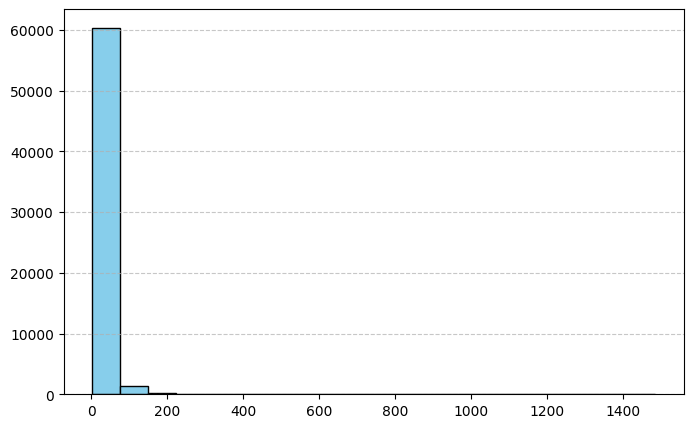

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(df['word_count'], bins=20, color='skyblue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# df.drop(columns=['word_count'], inplace=True)

### Tiền xử lý dữ liệu

In [13]:
df = df[df['sentiment'].isin(["negative", "positive", "neutral"])]
df['sentiment'].value_counts()

,count
sentiment,
negative,30858
neutral,19708
positive,11426


In [14]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

ps = PorterStemmer()
stop_word = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_word])
    text = ' '.join(ps.stem(word) for word in word_tokenize(text))
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d", '', text)
    return text

df["comment"] = df["comment"].apply(preprocess_text)
df_test["comment"] = df_test["comment"].apply(preprocess_text)

df.head()


,comment,sentiment,word_count
0,realli sad,negative,2
1,plot twist jarrid work togeth dealership mak...,neutral,18
2,think wrong deliveri man automat think tip wa...,negative,20
3,fuck cnn the fake news network,negative,6
4,sure mean left,neutral,6


In [19]:
from collections import Counter
corpus = [word for text in df['comment'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common(2000)

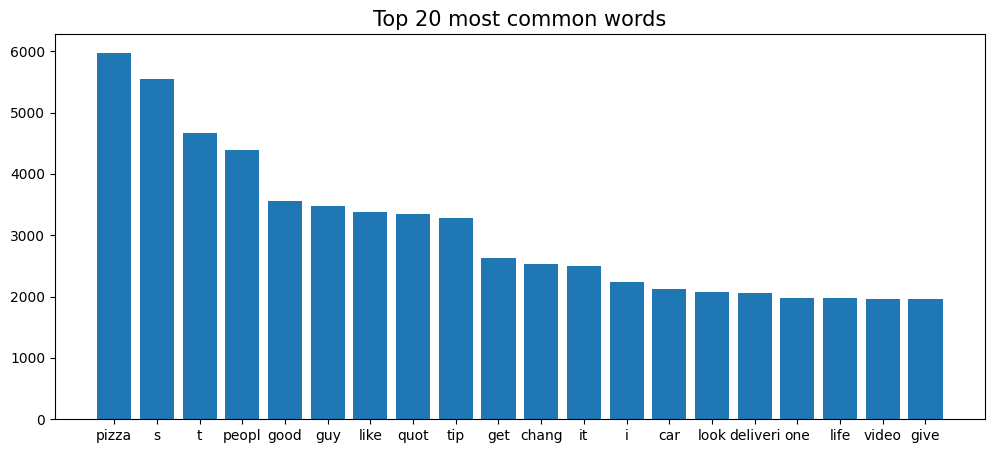

In [20]:
import matplotlib.pyplot as plt
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

In [21]:
# Tách dữ liệu theo nhãn
negative_samples = df[df['sentiment'] == 'negative']
neutral_samples = df[df['sentiment'] == 'neutral']
positive_samples = df[df['sentiment'] == 'positive']

# Lấy mẫu lại (undersample) cho các nhãn lớn hơn
negative_downsampled = resample(negative_samples,
                                replace=False,    # Không thay thế
                                n_samples=len(positive_samples),  # Bằng số lượng nhỏ nhất
                                random_state=42)

neutral_downsampled = resample(neutral_samples,
                               replace=False,
                               n_samples=len(positive_samples),
                               random_state=42)

# Kết hợp lại
df = pd.concat([negative_downsampled, neutral_downsampled, positive_samples])

In [22]:
df['sentiment'].value_counts()

,count
sentiment,
negative,11426
neutral,11426
positive,11426


In [23]:
print("min: ", df['word_count'].min())
print("max: ", df['word_count'].max())
print("mean: ", df['word_count'].mean())
print("median: ", df['word_count'].median())
print("std: ", df['word_count'].std())

min:  1
max:  1139
mean:  17.507555866736684
median:  11.0
std:  27.522555731369863


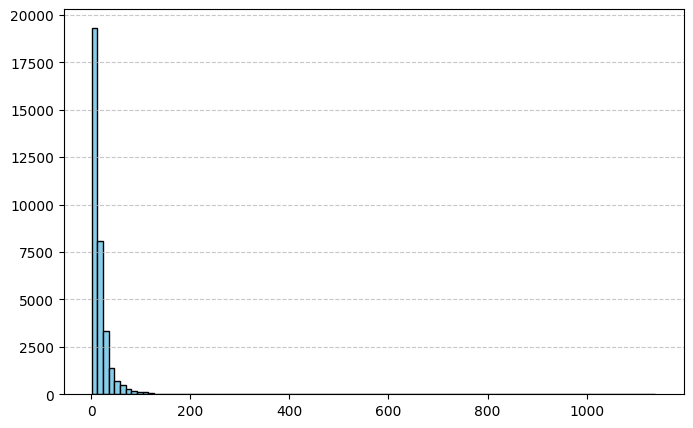

In [24]:
plt.figure(figsize=(8, 5))
plt.hist(df['word_count'], bins=100, color='skyblue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['comment']:
    r = [vocab_to_int[word] for word in text.split() if word in vocab_to_int]
    reviews_int.append(r)

reviews_int_test = []
for text in df_test['comment']:
    r = [vocab_to_int[word] for word in text.split() if word in vocab_to_int]
    reviews_int_test.append(r)

print(reviews_int[0])
print(reviews_int_test[0])
print(vocab_to_int)
print(len(reviews_int_test))

[30, 3, 609, 33, 598, 41, 81]
[465, 114, 88, 482, 1956, 683, 48]
{'pizza': 1, 's': 2, 't': 3, 'peopl': 4, 'good': 5, 'guy': 6, 'like': 7, 'quot': 8, 'tip': 9, 'get': 10, 'chang': 11, 'it': 12, 'i': 13, 'car': 14, 'look': 15, 'deliveri': 16, 'one': 17, 'life': 18, 'video': 19, 'give': 20, 'would': 21, 'man': 22, 'judg': 23, 'that': 24, 'back': 25, 'love': 26, 'make': 27, 'got': 28, 'know': 29, 'don': 30, 'want': 31, 'dollar': 32, 'internet': 33, 'hope': 34, 'oh': 35, 'time': 36, 'go': 37, 'say': 38, 'm': 39, 'see': 40, 'fuck': 41, 'use': 42, 'think': 43, 'a': 44, 'way': 45, 'bill': 46, 'href': 47, 'money': 48, 'right': 49, 'never': 50, 'lol': 51, 'work': 52, 'cri': 53, 'you': 54, 'god': 55, 'school': 56, 'bad': 57, 'even': 58, 'busi': 59, 'need': 60, 'thing': 61, 'job': 62, 'person': 63, 'gave': 64, 'realli': 65, 'cnn': 66, 'alway': 67, 'year': 68, 'he': 69, 'day': 70, 'said': 71, 'someon': 72, 'still': 73, 'end': 74, 'lot': 75, 'place': 76, 'him': 77, 'nice': 78, 'happen': 79, 'didn': 

In [54]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(review_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

In [55]:
import numpy as np
max_token_len = 30
features = Padding(reviews_int, max_token_len)
features_test = Padding(reviews_int_test, max_token_len)
print(features[0, :])
print(len(features))
print(len(features_test))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  30   3 609  33 598  41  81]
34278
15498


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, df['sentiment'].to_numpy(),
                                                        test_size=0.2, random_state=42,
                                                        stratify=df['sentiment'])
X_test = features_test
y_test = df_test['sentiment'].to_numpy()

In [57]:
print(X_train[:5])  # Xem 5 hàng đầu tiên của X_train
print(y_train[:5])  # Xem 5 giá trị đầu tiên của y_train


[[ 620   42   14  403  429  147  219   10   14  256  287  464   58   11
  1153  935  232  156  224   12  396   70  257  136  414   38    8 1485
   259    8]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  123]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   66  386
    41 1925]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0 1799    1
    15    5]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  221   27
    22  218]]
['negative' 'neutral' 'negative' 'positive' 'negative']


In [58]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Chuyển đổi y_train, y_test, y_valid thành số
# ['negative', 'neutral', 'positive'] -> [0, 1, 2]
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

In [61]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

## Model

### Helper

In [87]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    correct = preds.eq(labels.view_as(preds)).sum()
    acc = correct.float() / preds.shape[0]
    return acc


def calculate_accuracy(model, test_loader, device):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (không tính gradient)

    correct = 0
    total = 0

    with torch.no_grad():  # Tắt tính toán gradient để giảm bộ nhớ và tính toán
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Đưa dữ liệu vào đúng thiết bị

            # Khởi tạo trạng thái ẩn
            hidden = model.init_hidden(inputs.size(0))
            hidden = tuple([each.data for each in hidden])  # Đảm bảo trạng thái ẩn là tensor

            # Dự đoán đầu ra từ mô hình
            outputs, hidden = model(inputs, hidden)  # Truyền hidden vào mô hình

            # Tính độ chính xác cho batch
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # So sánh dự đoán và nhãn thực tế

    accuracy = correct / total * 100  # Tính độ chính xác (%) của mô hình
    return accuracy


#### Pretrain Embedding

##### GoogleNews-vectors-negative300-SLIM

In [63]:
from gensim.models import KeyedVectors

path_to_google_news = "pre-trained/GoogleNews-vectors-negative300-SLIM.bin"

google_news_vectors = KeyedVectors.load_word2vec_format(path_to_google_news, binary=True)

In [64]:
import numpy as np

embedding_dim = 300  # GoogleNews vector size
vocab_size = len(vocab_to_int) + 1

# Khởi tạo ma trận embedding với giá trị ngẫu nhiên
embedding_matrix = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_dim))

# Lấy embedding cho các từ trong từ điển của bạn
for word, idx in vocab_to_int.items():
    if word in google_news_vectors.key_to_index:
        embedding_matrix[idx] = google_news_vectors[word]

# Chuyển ma trận embedding thành tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

### LSTM

In [65]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)
        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [66]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3  # 0, 1, 2
embedding_dim = 64
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [67]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 30
lr = 0.001
clip = 5  # gradient clipping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/LSTM/weight_{epoch}.pth")

Epoch: 1/30... Train Loss: 0.973495... Val Loss: 0.920403... Train Acc: 55.29%... Val Acc: 61.53%
Epoch: 2/30... Train Loss: 0.879308... Val Loss: 0.874702... Train Acc: 66.07%... Val Acc: 66.40%
Epoch: 3/30... Train Loss: 0.842629... Val Loss: 0.870324... Train Acc: 70.11%... Val Acc: 67.08%
Epoch: 4/30... Train Loss: 0.821886... Val Loss: 0.862616... Train Acc: 72.31%... Val Acc: 68.02%
Epoch: 5/30... Train Loss: 0.806888... Val Loss: 0.857931... Train Acc: 73.87%... Val Acc: 68.63%
Epoch: 6/30... Train Loss: 0.794293... Val Loss: 0.850342... Train Acc: 75.30%... Val Acc: 69.24%
Epoch: 7/30... Train Loss: 0.782257... Val Loss: 0.848300... Train Acc: 76.44%... Val Acc: 69.58%
Epoch: 8/30... Train Loss: 0.773867... Val Loss: 0.845968... Train Acc: 77.34%... Val Acc: 69.87%
Epoch: 9/30... Train Loss: 0.765729... Val Loss: 0.845020... Train Acc: 78.31%... Val Acc: 69.82%
Epoch: 10/30... Train Loss: 0.760728... Val Loss: 0.847841... Train Acc: 78.84%... Val Acc: 69.72%
Epoch: 11/30... Tra

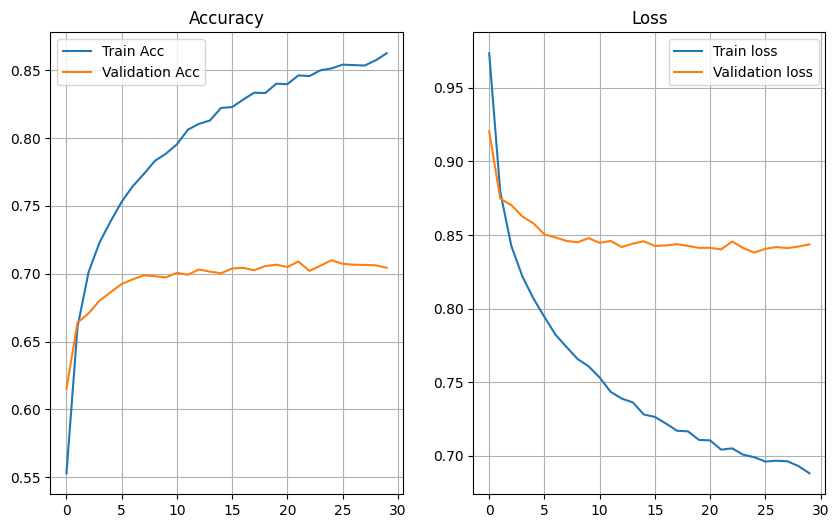

In [68]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# model.load_state_dict(torch.load('weights/LSTM/weight_{epoch}.pth'))

In [109]:
calculate_accuracy(model, test_loader, device)

70.29294102464834

In [108]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i hate you")

0

### LSTM + Pre-trained Embedding

In [113]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)

        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [114]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 300
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2)
model.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)  # freeze=True để giữ nguyên trọng số
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [115]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 30
lr = 0.001
clip = 5  # gradient clipping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/LSTM_Pre-trained/weight_{epoch}.pth")

Epoch: 1/30... Train Loss: 0.961464... Val Loss: 0.965523... Train Acc: 56.78%... Val Acc: 57.43%
Epoch: 2/30... Train Loss: 0.903009... Val Loss: 0.920197... Train Acc: 63.85%... Val Acc: 61.68%
Epoch: 3/30... Train Loss: 0.883409... Val Loss: 0.894914... Train Acc: 65.83%... Val Acc: 64.51%
Epoch: 4/30... Train Loss: 0.879407... Val Loss: 0.892789... Train Acc: 66.43%... Val Acc: 64.56%
Epoch: 5/30... Train Loss: 0.868281... Val Loss: 0.884817... Train Acc: 67.49%... Val Acc: 65.56%
Epoch: 6/30... Train Loss: 0.863647... Val Loss: 0.891792... Train Acc: 67.87%... Val Acc: 64.86%
Epoch: 7/30... Train Loss: 0.859054... Val Loss: 0.885984... Train Acc: 68.38%... Val Acc: 65.35%
Epoch: 8/30... Train Loss: 0.856127... Val Loss: 0.884673... Train Acc: 68.84%... Val Acc: 65.62%
Epoch: 9/30... Train Loss: 0.851571... Val Loss: 0.890692... Train Acc: 69.17%... Val Acc: 65.07%
Epoch: 10/30... Train Loss: 0.844497... Val Loss: 0.883202... Train Acc: 69.98%... Val Acc: 65.58%
Epoch: 11/30... Tra

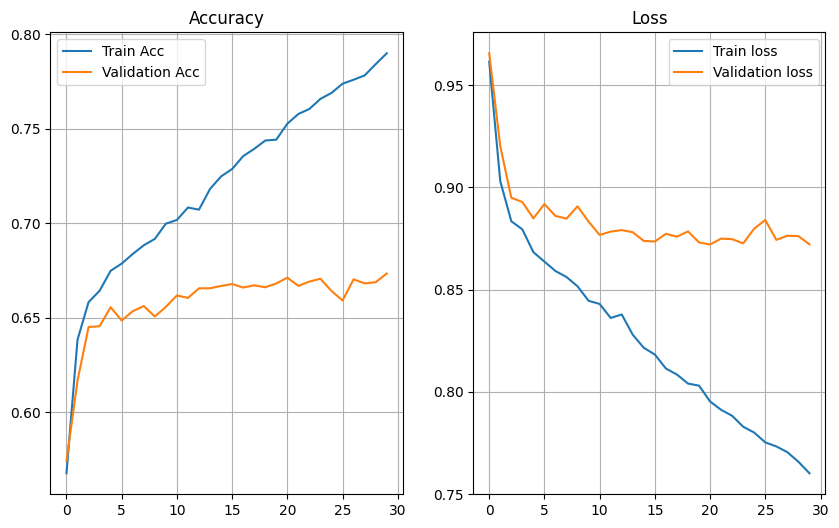

In [116]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [117]:
model.load_state_dict(torch.load('weights/LSTM_Pre-trained/weight_29.pth'))

<ipython-input-117-13e06fe2972b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/LSTM_Pre-trained/weight_29.pth'))


<All keys matched successfully>

In [118]:
calculate_accuracy(model, test_loader, device)

68.55723319137952

In [119]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

2

### Bidirectional LSTM

In [128]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)
        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        return hidden

In [129]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 64
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [130]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []
# Hyperparameters
epochs = 50
lr = 0.001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/biLSTM/weight_{epoch}.pth")

Epoch: 1/50... Train Loss: 0.962043... Val Loss: 0.912730... Train Acc: 56.81%... Val Acc: 62.41%
Epoch: 2/50... Train Loss: 0.877506... Val Loss: 0.899864... Train Acc: 66.40%... Val Acc: 63.85%
Epoch: 3/50... Train Loss: 0.853280... Val Loss: 0.882999... Train Acc: 69.12%... Val Acc: 65.81%
Epoch: 4/50... Train Loss: 0.831787... Val Loss: 0.864121... Train Acc: 71.41%... Val Acc: 68.00%
Epoch: 5/50... Train Loss: 0.821867... Val Loss: 0.859702... Train Acc: 72.38%... Val Acc: 68.31%
Epoch: 6/50... Train Loss: 0.803271... Val Loss: 0.860942... Train Acc: 74.32%... Val Acc: 68.18%
Epoch: 7/50... Train Loss: 0.790129... Val Loss: 0.855824... Train Acc: 75.74%... Val Acc: 69.08%
Epoch: 8/50... Train Loss: 0.782918... Val Loss: 0.854142... Train Acc: 76.43%... Val Acc: 68.96%
Epoch: 9/50... Train Loss: 0.774227... Val Loss: 0.850061... Train Acc: 77.48%... Val Acc: 69.40%
Epoch: 10/50... Train Loss: 0.765490... Val Loss: 0.845910... Train Acc: 78.35%... Val Acc: 70.08%
Epoch: 11/50... Tra

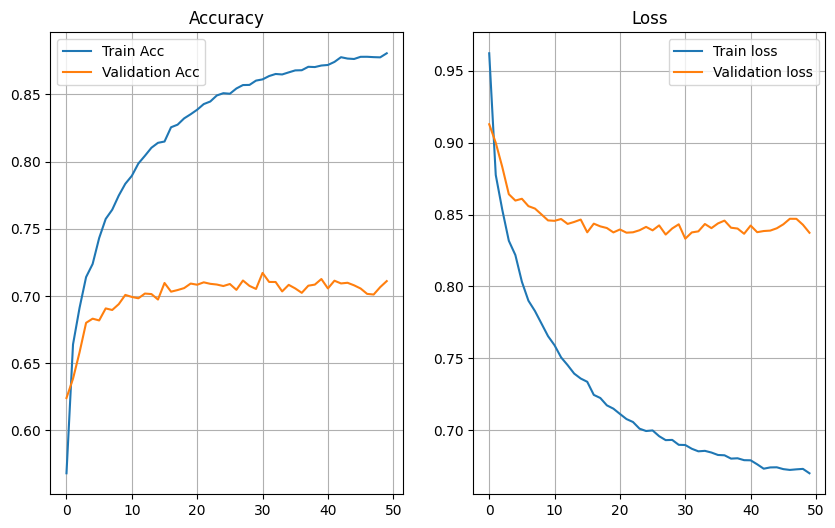

In [131]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# model.load_state_dict(torch.load('weights/biLSTM/weight_{epoch}.pth'))

In [136]:
calculate_accuracy(model, test_loader, device)

70.73170731707317

In [133]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

2

### Bidirectional LSTM + Attension

In [147]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, lstm_out):
        attention_scores = torch.matmul(lstm_out, self.attention_weights)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights.unsqueeze(2) * lstm_out, dim=1)
        return weighted_sum

In [148]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True, bidirectional=True)

        self.attention = AttentionLayer(hidden_dim * 2)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.attention(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)

        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        return hidden

In [149]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 64
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): AttentionLayer()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [150]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 50
lr = 0.001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/biLSTM_Attension/weight_{epoch}.pth")


Epoch: 1/50... Train Loss: 0.984479... Val Loss: 0.929203... Train Acc: 53.90%... Val Acc: 60.32%
Epoch: 2/50... Train Loss: 0.889611... Val Loss: 0.895608... Train Acc: 65.10%... Val Acc: 64.43%
Epoch: 3/50... Train Loss: 0.855299... Val Loss: 0.874887... Train Acc: 68.76%... Val Acc: 66.39%
Epoch: 4/50... Train Loss: 0.834887... Val Loss: 0.864153... Train Acc: 70.86%... Val Acc: 67.82%
Epoch: 5/50... Train Loss: 0.827479... Val Loss: 0.869010... Train Acc: 71.85%... Val Acc: 67.27%
Epoch: 6/50... Train Loss: 0.817553... Val Loss: 0.858809... Train Acc: 72.76%... Val Acc: 68.24%
Epoch: 7/50... Train Loss: 0.805789... Val Loss: 0.851969... Train Acc: 74.00%... Val Acc: 69.18%
Epoch: 8/50... Train Loss: 0.797624... Val Loss: 0.854214... Train Acc: 74.92%... Val Acc: 68.90%
Epoch: 9/50... Train Loss: 0.793030... Val Loss: 0.847290... Train Acc: 75.32%... Val Acc: 69.53%
Epoch: 10/50... Train Loss: 0.780277... Val Loss: 0.851320... Train Acc: 76.71%... Val Acc: 69.37%
Epoch: 11/50... Tra

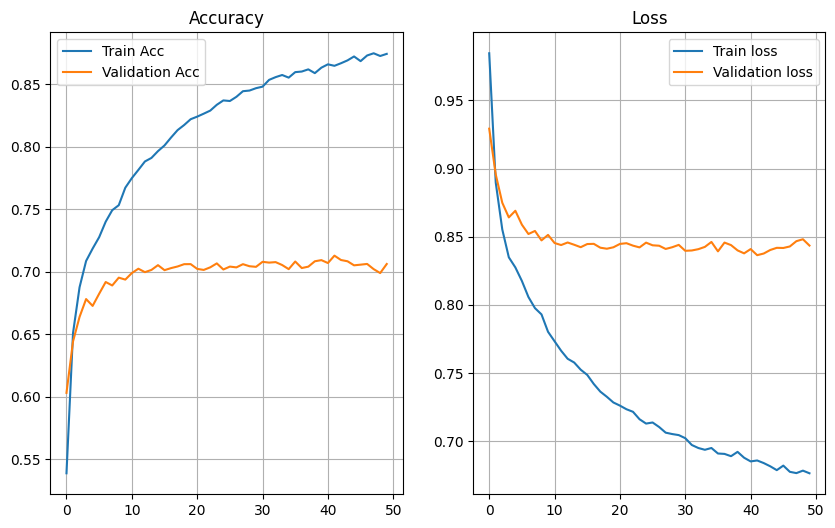

In [151]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [152]:
# model.load_state_dict(torch.load('weights/biLSTM_Attension/weight_{epoch}.pth'))

In [153]:
calculate_accuracy(model, test_loader, device)

70.87366111756356

In [154]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

2

### Bidirectional LSTM + Attension + Pre-trained Embedding

In [164]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, lstm_out):
        attention_scores = torch.matmul(lstm_out, self.attention_weights)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights.unsqueeze(2) * lstm_out, dim=1)
        return weighted_sum

In [165]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True, bidirectional=True)

        self.attention = AttentionLayer(hidden_dim * 2)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.attention(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)

        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        return hidden

In [166]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 300
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
model.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)  # freeze=True để giữ nguyên trọng số
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): AttentionLayer()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [167]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 50
lr = 0.001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/biLSTM_Attension_Pre-trained/weight_{epoch}.pth")


Epoch: 1/50... Train Loss: 0.993344... Val Loss: 1.075463... Train Acc: 52.21%... Val Acc: 46.70%
Epoch: 2/50... Train Loss: 0.930246... Val Loss: 0.949197... Train Acc: 61.12%... Val Acc: 59.34%
Epoch: 3/50... Train Loss: 0.900361... Val Loss: 0.906756... Train Acc: 64.24%... Val Acc: 63.57%
Epoch: 4/50... Train Loss: 0.889355... Val Loss: 0.910452... Train Acc: 65.21%... Val Acc: 62.70%
Epoch: 5/50... Train Loss: 0.878375... Val Loss: 0.900715... Train Acc: 66.53%... Val Acc: 63.88%
Epoch: 6/50... Train Loss: 0.873447... Val Loss: 0.887694... Train Acc: 66.86%... Val Acc: 65.55%
Epoch: 7/50... Train Loss: 0.877378... Val Loss: 0.906589... Train Acc: 66.61%... Val Acc: 63.70%
Epoch: 8/50... Train Loss: 0.872100... Val Loss: 0.889790... Train Acc: 67.10%... Val Acc: 65.00%
Epoch: 9/50... Train Loss: 0.867450... Val Loss: 0.891147... Train Acc: 67.58%... Val Acc: 65.19%
Epoch: 10/50... Train Loss: 0.858270... Val Loss: 0.912558... Train Acc: 68.58%... Val Acc: 62.91%
Epoch: 11/50... Tra

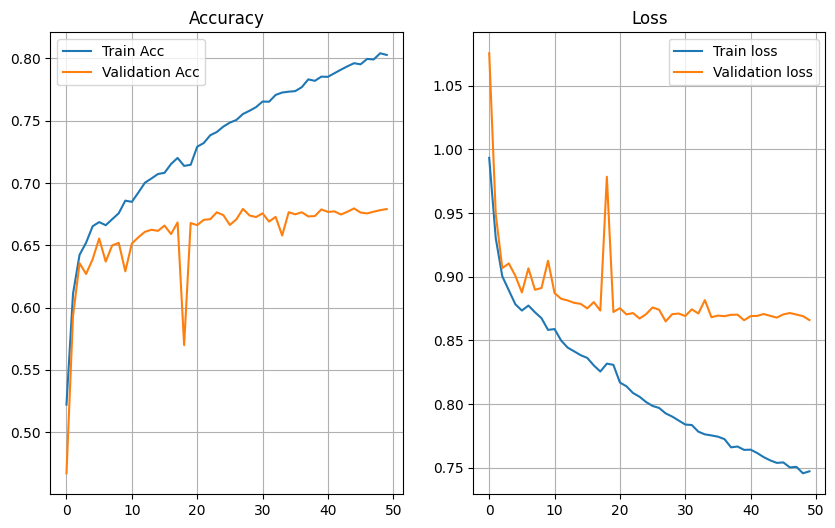

In [168]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [169]:
# model.load_state_dict(torch.load('weights/biLSTM_Attension_Pre-trained/weight_{epoch}.pth'))

In [172]:
calculate_accuracy(model, test_loader, device)

68.58304297328688

In [171]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

2